# King County Housing Linear Regression Project by Mike Van Eaton

## Business Understanding

House appraisers have software available to them to help predict the value of homes recently put on the market.  There are many features of houses that are both objective and subjective.  The data is gathered by realtors who are trying to get the most value for their clients house.  This is a problem for a predictive model for the house appraisers. House appraisers verify the realtors descriptions and quality of subjective features.  A quality predictivice model will help both for buyer and seller feel good about their purchase and for the realtor and appraiser who depend on each other for accurate and valid valuation.  This project looks at many mulitple listing service (MLS) features and distance to neighborhood locations such as schools, transit, coffee shops to increase the models explanatin to the spread of house prices in the Washington states King County region. 


## Data Understanding

The data in this project comes from Washington state's records of housing sales for the years 2020-2011 , a list of zip codes representing 693 cities in Washington state, and  Washington state's King County GIS data hub from reports created on 9/22/2022.  The housing authority maintains current records for all King County realestate transactions where the price of the sale of the house is recorded.  The geographic information system (GIS) data hub contains all data that includes a location for King County.  This data set contains approximately 28,000 points after cleaning.  The data includes typical MLS quantitative features as size of living area, lot size, and the number of bedrooms and bathrooms.  Also included are qualitative features such as nuisances, views, condition, and quality grade.  Additional potential features are comparing distances to schools, parks, and coffee shops, etc. to the sale price.  The MLS features are used as they are typical descriptors for a property price that potential home buyer will see.  Nearby neighborhood features were selected for their potential subconcious consideration when thinking about house location and the price of the house.  One issue with the distances gathered for this analysis is they are not driving direction distances but rather straight line distances.  Both sets of data also have potetial data entry errors due to human error.


## Data Preparation

### Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#%matplotlib nbagg
#plt.style.use('seaborn')

kcdf = pd.read_csv('data/kc_house_data.csv')
WAzips = pd.read_csv('data/wa zip.csv')
kcwaste = pd.read_csv('data/Solid_Waste_Facilities_Location___sw_facilities_point.csv')
kcpoints = pd.read_csv('data/Common_Points_of_Interest_for_King_County____common_interest_point.csv')
kcinspect = pd.read_csv('data/Restaurant_Inspections___restaurant_inspections_point.csv')

## King County Housing Data

In [2]:
# Columns for the king county data frame
kcdf.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

In [3]:
# Drop ['id'] column, unneeded for project.
kcdf.drop('id', axis = 1, inplace = True)
# Rename ['date'] to ['selldate'] for clarity.
kcdf.rename(columns = {'date':'selldate'}, inplace = True)

In [4]:
kcdf.info() # checking for consistant column entries, data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   selldate       30155 non-null  object 
 1   price          30155 non-null  float64
 2   bedrooms       30155 non-null  int64  
 3   bathrooms      30155 non-null  float64
 4   sqft_living    30155 non-null  int64  
 5   sqft_lot       30155 non-null  int64  
 6   floors         30155 non-null  float64
 7   waterfront     30155 non-null  object 
 8   greenbelt      30155 non-null  object 
 9   nuisance       30155 non-null  object 
 10  view           30155 non-null  object 
 11  condition      30155 non-null  object 
 12  grade          30155 non-null  object 
 13  heat_source    30123 non-null  object 
 14  sewer_system   30141 non-null  object 
 15  sqft_above     30155 non-null  int64  
 16  sqft_basement  30155 non-null  int64  
 17  sqft_garage    30155 non-null  int64  
 18  sqft_p

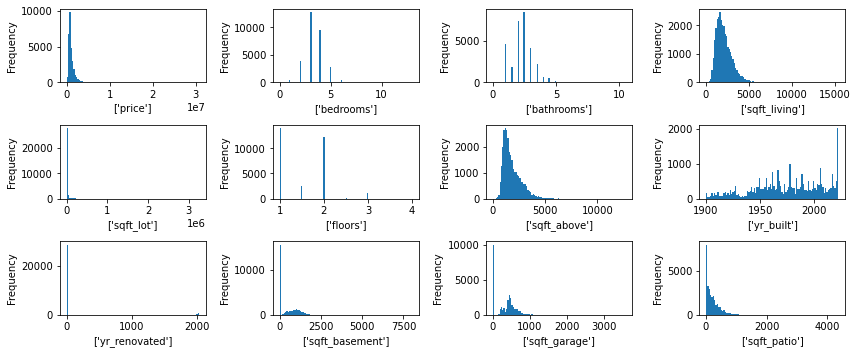

In [5]:
#Checking features for outliers for MLS numeric features

numeric_features = kcdf[['price','bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'sqft_above',
                         'yr_built','yr_renovated','sqft_basement', 'sqft_garage', 'sqft_patio'
                        ]].columns

fig, axes = plt.subplots(3,4, figsize=(12,5))
axe = axes.ravel()
for index, feature in enumerate(numeric_features):
    kcdf[feature].plot.hist(ax=axe[index],bins = 100).set_xlabel([feature])
    fig.tight_layout(pad=1)

In [6]:
#['selldate'] to datetime .dtype
kcdf['selldate'] = pd.to_datetime(kcdf['selldate'])
kcdf['selldate'].dtype

dtype('<M8[ns]')

In [7]:
#['yr_built'] to datetime .dtype
kcdf['yr_built'] = pd.to_datetime(kcdf.yr_built, format = '%Y').dt.year
kcdf['yr_built'].dtype

dtype('int64')

In [8]:
# Calculate ['age'] of house from  ['yr_built'] or ['yr_renovated'] to ['selldate'] 
kcdf['age'] = np.where( kcdf['yr_renovated'] != 0,kcdf['selldate'].apply(
               lambda x: x.year) - kcdf['yr_renovated'],
                kcdf['selldate'].apply(lambda x: x.year) - kcdf['yr_built']
               )
kcdf['age'].head(5)

0    53
1    71
2    65
3    11
4     9
Name: age, dtype: int64

In [9]:
#['view'] and ['grade'] descriptions to compare description syntax 
kcdf['view'].value_counts(), kcdf['grade'].value_counts()

(NONE         26589
 AVERAGE       1915
 GOOD           878
 EXCELLENT      553
 FAIR           220
 Name: view, dtype: int64,
 7 Average        11697
 8 Good            9410
 9 Better          3806
 6 Low Average     2858
 10 Very Good      1371
 11 Excellent       406
 5 Fair             393
 12 Luxury          122
 4 Low               51
 13 Mansion          24
 3 Poor              13
 1 Cabin              2
 2 Substandard        2
 Name: grade, dtype: int64)

In [10]:
# Split GRADE into value and description columns, delete grade combined value, make value int64

kcgrade = kcdf['grade'].str.split(pat = ' ', expand = True)
kcdf.insert(loc = 13, column = 'grade val', value = kcgrade[0])
kcdf.insert(loc = 14, column = 'grade desc', value = kcgrade[1])
kcdf.drop('grade', axis = 1, inplace = True)

kcdf['grade val']=kcdf['grade val'].astype('int64')
kcdf['grade val'].dtype

# Split ADDRESS into value and description columns, delete grade combined value
kcaddress = kcdf['address'].str.split(pat = ',', expand = True)
kcaddressstatezip=kcaddress[2].str.split(pat = ' ', expand = True)
kcdf.insert(loc = 23, column = 'street', value = kcaddress[0])
kcdf.insert(loc = 24, column = 'city', value = kcaddress[1])
kcdf.insert(loc = 25, column = 'state', value = kcaddressstatezip[1])
kcdf.insert(loc = 26, column = 'zip', value = kcaddressstatezip[2])
kcdf.drop('address', axis = 1, inplace = True)

# Change spelling for [view] features to match other feature spellings
kcdf['state'] = kcdf['state'].str.replace('Washington','WA')
kcdf['view'] = kcdf['view'].str.replace('NONE','None')
kcdf['view'] = kcdf['view'].str.replace('AVERAGE','Average')
kcdf['view'] = kcdf['view'].str.replace('GOOD','Good')
kcdf['view'] = kcdf['view'].str.replace('EXCELLENT','Excellent')
kcdf['view'] = kcdf['view'].str.replace('FAIR','Fair')


kcdf.head(5)

,selldate,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_patio,yr_built,yr_renovated,street,city,state,zip,lat,long,age
0,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,40,1969,0,2102 Southeast 21st Court,Renton,WA,98055,47.461975,-122.19052,53
1,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,240,1950,0,11231 Greenwood Avenue North,Seattle,WA,98133,47.711525,-122.35591,71
2,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,0,1956,0,8504 South 113th Street,Seattle,WA,98178,47.502045,-122.22520,65
3,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,...,270,2010,0,4079 Letitia Avenue South,Seattle,WA,98118,47.566110,-122.29020,11
4,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,...,30,2012,0,2193 Northwest Talus Drive,Issaquah,WA,98027,47.532470,-122.07188,9


In [11]:
# Check for missing data
kcdf.isna().sum()

selldate          0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade val         0
grade desc        0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
street            0
city              0
state             0
zip              35
lat               0
long              0
age               0
dtype: int64

In [12]:
 #Drop missing data. Very few missing compared to size of data set.
kcdf = kcdf.dropna()
kcdf.isna().sum()

selldate         0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade val        0
grade desc       0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
street           0
city             0
state            0
zip              0
lat              0
long             0
age              0
dtype: int64

##  King County Zip Code List

In [13]:
# Check for column names for filtering.
WAzips.head(3)

,zip,Zipcode name,City,State,County Name
0,98520,"ABERDEEN, WA",ABERDEEN,WA,GRAYS HARBOR
1,98220,"ACME, WA",ACME,WA,WHATCOM
2,99101,"ADDY, WA",ADDY,WA,STEVENS


In [14]:
# Filter data for WA ["State"] and KING for ["County Name"]
kczip = WAzips[(WAzips["State"] == "WA") & (WAzips["County Name"] == "KING")]
kczip['County Name'].value_counts()

KING    115
Name: County Name, dtype: int64

In [15]:
kczip.dtypes

zip             object
Zipcode name    object
City            object
State           object
County Name     object
dtype: object

##  Merge King County Housing List and King County Zip Codes to clear bad entries

In [16]:
# Filter Housing data only zip codes in King county using zip code list by merging the data frames
#kcdfm - king county data frame merge
kcdfm=pd.merge(kcdf,kczip, left_on='zip',right_on='zip')
kcdfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29142 entries, 0 to 29141
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   selldate       29142 non-null  datetime64[ns]
 1   price          29142 non-null  float64       
 2   bedrooms       29142 non-null  int64         
 3   bathrooms      29142 non-null  float64       
 4   sqft_living    29142 non-null  int64         
 5   sqft_lot       29142 non-null  int64         
 6   floors         29142 non-null  float64       
 7   waterfront     29142 non-null  object        
 8   greenbelt      29142 non-null  object        
 9   nuisance       29142 non-null  object        
 10  view           29142 non-null  object        
 11  condition      29142 non-null  object        
 12  grade val      29142 non-null  int64         
 13  grade desc     29142 non-null  object        
 14  heat_source    29142 non-null  object        
 15  sewer_system   2914

In [17]:
# Remove any rows with the house price outside of three standard deviations (outlier removal)
#king county data frame merge outliers (removed)
kcdfmo = kcdfm[np.abs(stats.zscore(kcdfm['price'])) < 3]
kcdfmo

,selldate,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,city,state,zip,lat,long,age,Zipcode name,City,State,County Name
0,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,Renton,WA,98055,47.461975,-122.19052,53,"RENTON, WA",RENTON,WA,KING
1,2022-03-02,750000.0,3,2.0,1830,7969,1.0,NO,NO,NO,...,Renton,WA,98055,47.466730,-122.21400,14,"RENTON, WA",RENTON,WA,KING
2,2022-03-29,728000.0,4,2.0,2170,7520,1.0,NO,NO,NO,...,Renton,WA,98055,47.463930,-122.18974,49,"RENTON, WA",RENTON,WA,KING
3,2022-03-24,565000.0,4,2.0,1400,10364,1.5,NO,NO,NO,...,Renton,WA,98055,47.448450,-122.21243,51,"RENTON, WA",RENTON,WA,KING
4,2021-12-28,645000.0,3,2.0,1520,8250,1.0,NO,NO,NO,...,Renton,WA,98055,47.460870,-122.18869,40,"RENTON, WA",RENTON,WA,KING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29137,2022-05-17,395000.0,1,1.0,620,10400,1.5,NO,NO,YES,...,Skykomish,WA,98288,47.712560,-121.31959,41,"SKYKOMISH, WA",SKYKOMISH,WA,KING
29138,2021-07-09,328000.0,2,1.5,980,5000,2.0,NO,NO,NO,...,Skykomish,WA,98288,47.707580,-121.35905,18,"SKYKOMISH, WA",SKYKOMISH,WA,KING
29139,2022-01-26,600000.0,3,2.5,3150,989234,1.5,YES,NO,YES,...,Skykomish,WA,98288,47.714420,-121.27639,39,"SKYKOMISH, WA",SKYKOMISH,WA,KING
29140,2022-02-08,2451000.0,4,3.5,4050,204296,2.0,NO,NO,NO,...,Preston,WA,98050,47.557160,-121.94932,37,"PRESTON, WA",PRESTON,WA,KING


In [18]:
# Additionally remove rows of outliers beyond three standard deviations in the ['sqft_living']
# kcdfmosq - king county data frame outlier square foot living space (removed)
kcdfmosq = kcdfmo[np.abs(stats.zscore(kcdfmo['sqft_living'])) < 3]
kcdfmosq

,selldate,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,city,state,zip,lat,long,age,Zipcode name,City,State,County Name
0,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,Renton,WA,98055,47.461975,-122.19052,53,"RENTON, WA",RENTON,WA,KING
1,2022-03-02,750000.0,3,2.0,1830,7969,1.0,NO,NO,NO,...,Renton,WA,98055,47.466730,-122.21400,14,"RENTON, WA",RENTON,WA,KING
2,2022-03-29,728000.0,4,2.0,2170,7520,1.0,NO,NO,NO,...,Renton,WA,98055,47.463930,-122.18974,49,"RENTON, WA",RENTON,WA,KING
3,2022-03-24,565000.0,4,2.0,1400,10364,1.5,NO,NO,NO,...,Renton,WA,98055,47.448450,-122.21243,51,"RENTON, WA",RENTON,WA,KING
4,2021-12-28,645000.0,3,2.0,1520,8250,1.0,NO,NO,NO,...,Renton,WA,98055,47.460870,-122.18869,40,"RENTON, WA",RENTON,WA,KING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29137,2022-05-17,395000.0,1,1.0,620,10400,1.5,NO,NO,YES,...,Skykomish,WA,98288,47.712560,-121.31959,41,"SKYKOMISH, WA",SKYKOMISH,WA,KING
29138,2021-07-09,328000.0,2,1.5,980,5000,2.0,NO,NO,NO,...,Skykomish,WA,98288,47.707580,-121.35905,18,"SKYKOMISH, WA",SKYKOMISH,WA,KING
29139,2022-01-26,600000.0,3,2.5,3150,989234,1.5,YES,NO,YES,...,Skykomish,WA,98288,47.714420,-121.27639,39,"SKYKOMISH, WA",SKYKOMISH,WA,KING
29140,2022-02-08,2451000.0,4,3.5,4050,204296,2.0,NO,NO,NO,...,Preston,WA,98050,47.557160,-121.94932,37,"PRESTON, WA",PRESTON,WA,KING


##  King County Schools

### Elementary Schools

In [19]:
# Filter GIS point of interes for elementary schools.  Code 660 is for elementary schools.
kcEschools =kcpoints[kcpoints['CODE'] == 660]
kcEschools.head()

,X,Y,OBJECTID,FEATURE_ID,ESITE,CODE,NAME,ABB_NAME,ADDRESS,ZIPCODE
3,-122.264083,47.319432,4,7,33.0,660,Evergreen Heights Elementary School,Evergreen Heights,5602 S 316th St,98001.0
4,-122.261359,47.333845,5,6600283,692199.0,660,Meredith Hill Elementary School,Hill,5830 S 300th St,98001.0
5,-122.259132,47.468914,6,6600241,21158.0,660,Tukwila Elementary School,Tukwila,5939 S 149th St,98168.0
9,-122.138595,47.661808,10,612,568273.0,660,Benjamin Rush Elementary School,Rush,6101 152nd Ave NE,98052.0
10,-122.325166,47.484421,11,1268,152.0,660,Cedarhurst Elementary School,Cedarhurst,611 S 132nd St,98168.0


In [20]:
# Refine list for only Name, longitude, and latitude
kcEschools_reduced = kcEschools[['NAME','X','Y']]
kcEschools_reduced.head()

,NAME,X,Y
3,Evergreen Heights Elementary School,-122.264083,47.319432
4,Meredith Hill Elementary School,-122.261359,47.333845
5,Tukwila Elementary School,-122.259132,47.468914
9,Benjamin Rush Elementary School,-122.138595,47.661808
10,Cedarhurst Elementary School,-122.325166,47.484421


In [21]:
#create list of tuples: (latitude , longitude)
kcEschool_loc = np.array(list(zip(kcEschools_reduced.Y,kcEschools_reduced.X)))
#kcEschool_loc

### Middle Schools

In [22]:
# Filter GIS point of interes for middle schools.  Code 661 is for elementary schools.
kcMschools =kcpoints[kcpoints['CODE'] == 661]
kcMschools.head()

,X,Y,OBJECTID,FEATURE_ID,ESITE,CODE,NAME,ABB_NAME,ADDRESS,ZIPCODE
14,-122.220144,47.274526,15,6600534,57.0,661,Mt. Baker Middle School,Mt. Baker,620 37th St SE,98002.0
15,-122.229658,47.385693,16,6600644,616921.0,661,Mill Creek Middle School,Mill Creek,620 Central Ave N,98032.0
254,-122.454360,47.428631,255,770,21170.0,661,McMurray Middle School,McMurray,9329 SW Cemetery Rd,98070.0
257,-122.294872,47.682589,258,962,12297.0,661,Eckstein Middle School,Eckstein,3003 NE 75th St,98115.0
315,-122.119788,47.691700,316,633,12148.0,661,Redmond Middle School,Redmond Middle,10055 166th Ave NE,98052.0


In [23]:
# Refine list for only Name, latitude, and longitude
kcMschools_reduced = kcMschools[['NAME','X','Y']]
kcMschools_reduced.head()

,NAME,X,Y
14,Mt. Baker Middle School,-122.220144,47.274526
15,Mill Creek Middle School,-122.229658,47.385693
254,McMurray Middle School,-122.454360,47.428631
257,Eckstein Middle School,-122.294872,47.682589
315,Redmond Middle School,-122.119788,47.691700


In [24]:
#create list of tuples: (latitude , longitude)
kcMschool_loc = np.array(list(zip(kcMschools_reduced.Y,kcMschools_reduced.X)))
#kcMschool_loc

In [25]:
#columns = ['store_id', 'email', 'sales_channel', 'category']
#df['metadata'] = df[columns].to_dict(orient='records')

### High Schools

In [26]:
# Filter GIS point of interes for high schools.  Code 662 is for elementary schools.
kcHschools =kcpoints[kcpoints['CODE'] == 662]
kcHschools.head()

,X,Y,OBJECTID,FEATURE_ID,ESITE,CODE,NAME,ABB_NAME,ADDRESS,ZIPCODE
313,-122.207627,47.373404,314,379,8601.0,662,Kent-Meridian High School,Kent-Meridian,10020 SE 256th St,98030.0
324,-122.197680,47.604405,325,112,82.0,662,Bellevue High School,Bellevue,10416 SE Wolverine Way,98004.0
328,-122.198624,47.715496,329,507,42811.0,662,Juanita High School,Juanita,10601 NE 132nd St,98034.0
330,-122.294727,47.708042,331,1093,12282.0,662,Nathan Hale High School,Hale,10750 30th Ave NE,98125.0
398,-122.152348,47.501630,399,756,579312.0,662,Hazen High School,Hazen,1101 Hoquiam Ave NE,98059.0


In [27]:
# Refine list for only Name, latitude, and longitude
kcHschools_reduced = kcHschools[['NAME','X','Y']]
kcHschools_reduced.head()

,NAME,X,Y
313,Kent-Meridian High School,-122.207627,47.373404
324,Bellevue High School,-122.197680,47.604405
328,Juanita High School,-122.198624,47.715496
330,Nathan Hale High School,-122.294727,47.708042
398,Hazen High School,-122.152348,47.501630


In [28]:
#create list of tuples: (latitude , longitude)
kcHschool_loc = np.array(list(zip(kcHschools_reduced.Y,kcHschools_reduced.X)))
#kcHschool_loc

##  King County Solid Waste

In [29]:
kcwaste.head(5)

,X,Y,OBJECTID,TransSiteID,SITEADDR,SITETYPE,CITY,SITENAME,OWNER,IsActive,IsClosedLandfill,ClosedLandfillName
0,-122.178413,47.483646,1,4,3021 NE 4th St,Transfer Station,Renton,Renton,King County,Yes,NaN,NaN
1,-122.267774,47.433836,2,5,18800 Orilla Rd S,Transfer Station,Tukwila,Bow Lake,King County,Yes,Yes,Bow Lake Landfill
2,-122.259761,47.285164,3,6,35315 West Valley Hwy,Transfer Station,Algona,Algona,King County,Yes,NaN,NaN
3,-121.954398,47.205286,4,7,1650 Battersby St E,Transfer Station,Enumclaw,Enumclaw,King County,Yes,Yes,Enumclaw Landfill
4,-122.499497,47.435395,5,8,18900 Westside Hwy SE,Transfer Station,Vashon,Vashon,King County,Yes,Yes,Vashon Landfill


In [30]:
# Refine list for only Name, latitude, and longitude
kcwaste_reduced = kcwaste[['SITENAME','X','Y']]
kcwaste_reduced

,SITENAME,X,Y
0,Renton,-122.178413,47.483646
1,Bow Lake,-122.267774,47.433836
2,Algona,-122.259761,47.285164
3,Enumclaw,-121.954398,47.205286
4,Vashon,-122.499497,47.435395
5,Shoreline,-122.331846,47.749687
6,Houghton,-122.183508,47.662026
7,Factoria,-122.159177,47.582221
8,Cedar Falls,-121.761446,47.449135
9,Cedar Hills Regional Landfill,-122.047540,47.462462


In [31]:
#create list of tuples: (latitude , longitude)
waste_loc = np.array(list(zip(kcwaste_reduced.Y,kcwaste_reduced.X)))
#waste_loc

## King County Churches

In [32]:
# Filter GIS point of interes for churches.  Code 800 is for churches.
kcchurch = kcpoints[kcpoints['CODE'] == 800]

In [33]:
# Refine list for only Name, latitude, and longitude
kcchurch_reduced = kcchurch[['NAME','X','Y']]
kcchurch_reduced.head()

,NAME,X,Y
4194,UNITY CHURCH,-122.340705,47.620133
4195,CROWNHILL UNITED METHODIST CHURCH,-122.373708,47.690945
4196,ST. MARGARET CATHOLIC CHURCH,-122.375265,47.648951
4197,CHURCH,-122.384288,47.648659
4198,GRACE FELLOWSHIP CHURCH,-122.362299,47.674390


In [34]:
#create list of tuples: (latitude , longitude)
church_loc = np.array(list(zip(kcchurch_reduced.Y,kcchurch_reduced.X)))

## King County Parks

In [35]:
# Filter GIS point of interes for parks.  Code 600 is for parks.
kcparks = kcpoints[kcpoints['CODE'] == 600]

In [36]:
# Refine list for only Name, latitude, and longitude
kcparks_reduced = kcparks[['NAME','X','Y']]
kcparks_reduced.head()

,NAME,X,Y
19,Island Center Forest Natural Area,-122.472494,47.438270
27,Counterbalance Park,-122.356324,47.625681
31,Bear Creek Park - Redmond,-122.108619,47.672285
32,McCormick Park - Bellevue,-122.186478,47.502681
34,Richmond Beach Center,-122.385011,47.771882


In [37]:
#create list of tuples: (latitude , longitude)
parks_loc = np.array(list(zip(kcparks_reduced.Y,kcparks_reduced.X)))

## King County Transit Stations

In [38]:
# Filter GIS point of interes for transit stations.  Code 510 is for transit stations.
kctransit = kcpoints[kcpoints['CODE'] == 510]

In [39]:
# Refine list for only Name, latitude, and longitude
kctransit_reduced = kctransit[['NAME','X','Y']]
kctransit_reduced.head()

,NAME,X,Y
42,U District Link Light Rail Station,-122.313981,47.660104
151,Mercer Island P&R during construction,-122.231997,47.588452
160,Capitol Hill Link Light Rail Station,-122.320200,47.619062
259,Kenmore Air Harbor Inc,-122.257891,47.757110
261,SODO Link Light Rail Station,-122.327331,47.581797


In [40]:
#create list of tuples: (latitude , longitude)
transit_loc = np.array(list(zip(kctransit_reduced.Y,kctransit_reduced.X)))

## King County Starbucks

In [41]:
kcinspect.head()

,X,Y,OBJECTID,FEATURE_ID,NAME,PROGRAM_IDENTIFIER,SEAT_CAP,RISK,ADDRESS,PHONE,...,RESULT_INSPECTION,CLOSE_BUS_INSPECTION,VIOLATIONTYPE,VIOLATIONDESCR,VIOLATIONPOINTS,RECORD_ID,FACILITY_NAME,CHAIN_NAME,CHAIN_ESTABLISHMENT,SITE_ADDRESS
0,-122.296415,47.662311,1,2,#807 TUTTA BELLA,#807 TUTTA BELLA,Seating 0-12,III,2746 NE 45TH ST,(206) 722-6400,...,Satisfactory,False,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,-122.296415,47.662311,2,3,#807 TUTTA BELLA,#807 TUTTA BELLA,Seating 0-12,III,2746 NE 45TH ST,(206) 722-6400,...,Satisfactory,False,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,-122.334587,47.648180,3,4,+MAS CAFE,+MAS CAFE,Seating 0-12,III,1906 N 34TH ST,(206) 491-4694,...,Satisfactory,False,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,-122.334587,47.648180,4,5,+MAS CAFE,+MAS CAFE,Seating 0-12,III,1906 N 34TH ST,(206) 491-4694,...,Satisfactory,False,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,-122.331727,47.629021,5,7,100 LB CLAM,100 LB CLAM,Seating 0-12,III,1001 FAIRVIEW AVE N Unit 1700A,(206) 369-2978,...,Incomplete,False,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [42]:
#Number of Starbucks in King County
len(kcinspect.loc[kcinspect['NAME'].str.contains('starbucks',case=False, regex =True)])

3958

In [43]:
# Filter file for only Starbucks' informatin
kcstar = kcinspect.loc[kcinspect['NAME'].str.contains('starbucks',case=False, regex =True)]

In [44]:
# Refine list for only Name, latitude, and longitude
kcstar_reduced = kcstar[['NAME','X','Y']]
kcstar_reduced.head()

,NAME,X,Y
26685,BON APPETIT CAFE @ Starbucks Center 5th FL,-122.335918,47.580901
26686,BON APPETIT CAFE @ Starbucks Center 5th FL,-122.335918,47.580901
26687,BON APPETIT CAFE @ Starbucks Center 5th FL,-122.335918,47.580901
26688,BON APPETIT CAFE @ Starbucks Center 5th FL,-122.335918,47.580901
26689,BON APPETIT CAFE @ Starbucks Center 5th FL,-122.335918,47.580901


In [45]:
#create list of tuples: (latitude , longitude)
star_loc = np.array(list(zip(kcstar_reduced.Y,kcstar_reduced.X)))

## King County House Data Coordinates

In [46]:
#create list of tuples: (latitude , longitude) for the housing data
loc_coord = np.array(list(zip(kcdfmo.lat,kcdfmo.long)))
loc_coord

array([[  47.461975, -122.19052 ],
       [  47.46673 , -122.214   ],
       [  47.46393 , -122.18974 ],
       ...,
       [  47.71442 , -121.27639 ],
       [  47.55716 , -121.94932 ],
       [  47.52372 , -121.93144 ]])

### Baseline Model 1a - compare highest correlated feature with price
A quick look at the correlated values to price to see how good a basemodel with one feature will do.

In [47]:
#MLS numeric data most correlated to price
kcdfm.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.616624
grade val        0.577933
sqft_above       0.545979
bathrooms        0.487963
sqft_patio       0.317627
lat              0.297603
bedrooms         0.290732
sqft_garage      0.267402
sqft_basement    0.246252
floors           0.199810
yr_built         0.106065
sqft_lot         0.086826
yr_renovated     0.085597
long             0.082432
age             -0.138162
Name: price, dtype: float64

In [48]:
X1 = kcdfm["sqft_living"]
y1 = kcdfm["price"]

In [49]:
model1 = sm.OLS(endog=y1, exog=sm.add_constant(X1))
model1

In [50]:
results1 = model1.fit()
results1

In [51]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.788e+04
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        05:56:12   Log-Likelihood:            -4.3379e+05
No. Observations:               29142   AIC:                         8.676e+05
Df Residuals:                   29140   BIC:                         8.676e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.219e+04   9919.150     -9.294      0.000   -1.12e+05   -7.28e+04
sqft_living   565.5280      4.230    133.705      0.000     557.238     573.818
==============================================================================
Omnibus:                    42176.216   Durbin-Watson:                   1.297
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         49934507.561
Skew:                           8.236   Prob(JB):                         0.00
Kurtosis:                     205.120   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 1a Conclusion
This model has a very low rsquared value only explaining $38\%$ of the price variance.  The coefficient represents a house with zero living area costs about $-\$92,000$.  Each increas in 1 square foot increases the value by $\$560$.  The p value shows that this is statiscally relavent.

### Base Model 1B - compare highest correlated feature with price outliers removed
This model removes the price outliers to see any quick improvement to the overall model.

In [52]:
#MLS numeric data most correlated to price
kcdfmo.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.638320
grade val        0.620132
sqft_above       0.561526
bathrooms        0.499907
lat              0.387137
bedrooms         0.338844
sqft_patio       0.294154
sqft_garage      0.278429
floors           0.242799
sqft_basement    0.220932
long             0.121130
yr_built         0.115352
sqft_lot         0.093967
yr_renovated     0.080101
age             -0.147850
Name: price, dtype: float64

In [53]:
X1b = kcdfmo["sqft_living"]
y1b = kcdfmo["price"]

In [54]:
model1b = sm.OLS(endog=y1b, exog=sm.add_constant(X1b))
model1b

In [55]:
results1b = model1b.fit()
results1b

In [56]:
results1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                 1.976e+04
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        05:56:13   Log-Likelihood:            -4.1577e+05
No. Observations:               28733   AIC:                         8.316e+05
Df Residuals:                   28731   BIC:                         8.316e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.504e+05   6936.151     21.684      0.000    1.37e+05    1.64e+05
sqft_living   427.4331      3.041    140.557      0.000     421.473     433.394
==============================================================================
Omnibus:                     6045.409   Durbin-Watson:                   1.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19303.716
Skew:                           1.072   Prob(JB):                         0.00
Kurtosis:                       6.395   Cond. No.                     5.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 1b Conclusion
This model has the price outliers removed. It has a bit higher rsquared value only explaining $41\%$ of the price variance.  The coefficient represents a house with zero living area costs about $\$150,000$ and an increase of $\$427$ a square foot added to the house.  The p value shows that this is statiscally relavent.

### Model 2 - use all numeric features with price outliers removed
This model uses the Model 1b with all numeric features added in to see any quick improvement to the model.

In [57]:
kcdfmo_features = kcdfmo.drop(['selldate','lat','long','street', 'Zipcode name','city', 'state','State', 'County Name','yr_built','yr_renovated','City'],axis=1)
kcdfmo_features.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade val',
       'grade desc', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'zip', 'age'],
      dtype='object')

In [58]:
numeric = kcdfmo_features.select_dtypes('number')
numeric

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade val,sqft_above,sqft_basement,sqft_garage,sqft_patio,age
0,675000.0,4,1.0,1180,7140,1.0,7,1180,0,0,40,53
1,750000.0,3,2.0,1830,7969,1.0,7,930,930,240,90,14
2,728000.0,4,2.0,2170,7520,1.0,7,1240,1240,490,60,49
3,565000.0,4,2.0,1400,10364,1.5,6,1400,0,330,330,51
4,645000.0,3,2.0,1520,8250,1.0,8,1190,590,420,200,40
...,...,...,...,...,...,...,...,...,...,...,...,...
29137,395000.0,1,1.0,620,10400,1.5,6,620,0,0,100,41
29138,328000.0,2,1.5,980,5000,2.0,7,980,0,0,260,18
29139,600000.0,3,2.5,3150,989234,1.5,7,2150,1390,0,2360,39
29140,2451000.0,4,3.5,4050,204296,2.0,9,2280,1770,750,1250,37


In [59]:
X2 = kcdfmo[numeric.columns].drop(['price'],axis=1)
y2 = kcdfmo["price"]


In [60]:
model2 = sm.OLS(endog=y2, exog=sm.add_constant(X2))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     2682.
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        05:56:13   Log-Likelihood:            -4.1314e+05
No. Observations:               28733   AIC:                         8.263e+05
Df Residuals:                   28721   BIC:                         8.264e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.416e+06    2.7e+04    -52.508      0.000   -1.47e+06   -1.36e+06
bedrooms      -5.082e+04   3544.991    -14.334      0.000   -5.78e+04   -4.39e+04
bathrooms      7.398e+04   5185.552     14.266      0.000    6.38e+04    8.41e+04
sqft_living     172.3532     11.868     14.522      0.000     149.091     195.616
sqft_lot          0.1699      0.043      3.971      0.000       0.086       0.254
floors        -4.008e+04   6466.238     -6.199      0.000   -5.28e+04   -2.74e+04
grade val      2.363e+05   3717.959     63.569      0.000    2.29e+05    2.44e+05
sqft_above      117.3480     12.069      9.723      0.000      93.692     141.004
sqft_basement    59.2530      8.761      6.763      0.000      42.081      76.425
sqft_garage    -186.6787     11.930    -15.648      0.000    -210.061    -163.296
sqft_patio       75.7462     11.619      6.519      0.000      52.972      98.521
age            3816.9153    115.783     32.966      0.000    3589.975    4043.856
==============================================================================
Omnibus:                     6426.221   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26092.207
Skew:                           1.060   Prob(JB):                         0.00
Kurtosis:                       7.159   Cond. No.                     6.79e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 2a Conclusion
This model has the price outliers removed and the other numeric features added in. It has a bit higher rsquared value only explaining $51\%$ of the price variance.  The coefficient represents a house with zero living area costs about $-\$1,420,000$ and an increase of $\$172$ a square foot, $\$74,000$ per bathroom, and about $\$3,800$ for each year in the age of the home added to the house.  There are some features that add negative value.  The p value shows that all features are statiscally relavent.

### Model 2b - use all numeric features with all columns' outliers removed 
This model removes all outliers from all columns.

In [61]:
#MLS numeric data most correlated to price with all outliers removed
kcdfmAo = numeric[(np.abs(stats.zscore(numeric)) < 3).all(axis=1)]
kcdfmAo.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.578097
grade val        0.563996
sqft_above       0.485585
bathrooms        0.443254
bedrooms         0.318784
sqft_patio       0.241885
sqft_garage      0.224421
floors           0.223609
sqft_basement    0.201274
sqft_lot         0.063679
age             -0.112120
Name: price, dtype: float64

In [62]:
len(kcdfmAo)

26634

In [63]:
X2b = kcdfmAo[numeric.columns].drop(['price'],axis=1)
y2b = kcdfmAo["price"]

In [64]:
model2b = sm.OLS(endog=y2b, exog=sm.add_constant(X2b))
model2b

In [65]:
results2b = model2b.fit()
results2b

In [66]:
results2b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     1949.
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        05:56:14   Log-Likelihood:            -3.7910e+05
No. Observations:               26634   AIC:                         7.582e+05
Df Residuals:                   26622   BIC:                         7.583e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.278e+06   2.59e+04    -49.287      0.000   -1.33e+06   -1.23e+06
bedrooms      -3.953e+04   3450.146    -11.456      0.000   -4.63e+04   -3.28e+04
bathrooms      6.716e+04   4959.340     13.542      0.000    5.74e+04    7.69e+04
sqft_living     160.3684     11.331     14.153      0.000     138.159     182.578
sqft_lot         -0.3102      0.148     -2.094      0.036      -0.601      -0.020
floors        -3.123e+04   6101.094     -5.118      0.000   -4.32e+04   -1.93e+04
grade val       2.18e+05   3589.093     60.734      0.000    2.11e+05    2.25e+05
sqft_above       97.6455     11.518      8.478      0.000      75.069     120.222
sqft_basement    53.2036      8.191      6.495      0.000      37.148      69.259
sqft_garage    -151.9938     11.601    -13.101      0.000    -174.733    -129.254
sqft_patio       85.7194     12.817      6.688      0.000      60.597     110.842
age            3690.2676    105.847     34.864      0.000    3482.803    3897.733
==============================================================================
Omnibus:                     3468.163   Durbin-Watson:                   1.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8081.234
Skew:                           0.769   Prob(JB):                         0.00
Kurtosis:                       5.218   Cond. No.                     2.25e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 2b Conclusion
This model has all column outliers removed. It has a much lower rsquared value compared to the previous model 2a, only explaining $45\%$ of the price variance.  The coefficient represents a house with zero living area costs about $-\$1,280,000$ and an increase of $\$160$ a square foot, $\$67,000$ per bathroom, and about $\$3,700$ for each year in the age of the home added to the house.  There are some features that add negative value.  The p value shows that all features are statiscally relavent.

###  Model 3, use numeric and categorical except [lat], [long], [Zipcode], [name], [ State], [County Name]
This model removes the outliers from the price column, has all of the numeric columns and adds categoric columns with one-hot encoding.

In [67]:
#Get only categoric features from kcdfmo (price outliers removed)
categoric = kcdfmo_features.select_dtypes('object')
categoric

,waterfront,greenbelt,nuisance,view,condition,grade desc,heat_source,sewer_system,zip
0,NO,NO,NO,None,Good,Average,Gas,PUBLIC,98055
1,NO,NO,NO,None,Average,Average,Gas,PUBLIC,98055
2,NO,NO,NO,None,Average,Average,Gas,PUBLIC,98055
3,NO,NO,NO,None,Good,Low,Electricity,PUBLIC,98055
4,NO,NO,NO,None,Average,Good,Gas,PUBLIC,98055
...,...,...,...,...,...,...,...,...,...
29137,NO,NO,YES,None,Average,Low,Electricity,PRIVATE,98288
29138,NO,NO,NO,None,Average,Average,Electricity,PUBLIC,98288
29139,YES,NO,YES,Average,Average,Average,Electricity,PRIVATE,98288
29140,NO,NO,NO,Good,Very Good,Better,Electricity,PRIVATE,98050


In [68]:
#Get only numeric features from kcdfmo (price outliers removed)
num = kcdfmo_features.select_dtypes('number')
num

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade val,sqft_above,sqft_basement,sqft_garage,sqft_patio,age
0,675000.0,4,1.0,1180,7140,1.0,7,1180,0,0,40,53
1,750000.0,3,2.0,1830,7969,1.0,7,930,930,240,90,14
2,728000.0,4,2.0,2170,7520,1.0,7,1240,1240,490,60,49
3,565000.0,4,2.0,1400,10364,1.5,6,1400,0,330,330,51
4,645000.0,3,2.0,1520,8250,1.0,8,1190,590,420,200,40
...,...,...,...,...,...,...,...,...,...,...,...,...
29137,395000.0,1,1.0,620,10400,1.5,6,620,0,0,100,41
29138,328000.0,2,1.5,980,5000,2.0,7,980,0,0,260,18
29139,600000.0,3,2.5,3150,989234,1.5,7,2150,1390,0,2360,39
29140,2451000.0,4,3.5,4050,204296,2.0,9,2280,1770,750,1250,37


In [69]:
# One-hot encode categoric features (create dummy columns)
# catwd - categoric features with dummies
# numcatwd - concatenate numeric and categoric dummy columns
catwd = pd.get_dummies(categoric, drop_first=True)
catwd.columns
numcatwd = pd.concat([num,catwd], axis=1)
numcatwd


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade val,sqft_above,sqft_basement,sqft_garage,...,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,zip_98288
0,675000.0,4,1.0,1180,7140,1.0,7,1180,0,0,...,0,0,0,0,0,0,0,0,0,0
1,750000.0,3,2.0,1830,7969,1.0,7,930,930,240,...,0,0,0,0,0,0,0,0,0,0
2,728000.0,4,2.0,2170,7520,1.0,7,1240,1240,490,...,0,0,0,0,0,0,0,0,0,0
3,565000.0,4,2.0,1400,10364,1.5,6,1400,0,330,...,0,0,0,0,0,0,0,0,0,0
4,645000.0,3,2.0,1520,8250,1.0,8,1190,590,420,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29137,395000.0,1,1.0,620,10400,1.5,6,620,0,0,...,0,0,0,0,0,0,0,0,0,1
29138,328000.0,2,1.5,980,5000,2.0,7,980,0,0,...,0,0,0,0,0,0,0,0,0,1
29139,600000.0,3,2.5,3150,989234,1.5,7,2150,1390,0,...,0,0,0,0,0,0,0,0,0,1
29140,2451000.0,4,3.5,4050,204296,2.0,9,2280,1770,750,...,0,0,0,0,0,0,0,0,0,0


In [70]:
X3 = numcatwd[numcatwd.drop(['price'],axis=1).columns]
y3 = numcatwd["price"]


In [71]:
model3 = sm.OLS(endog=y3, exog=sm.add_constant(X3))
results3 = model3.fit()
results3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     748.4
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        05:56:14   Log-Likelihood:            -4.0335e+05
No. Observations:               28733   AIC:                         8.069e+05
Df Residuals:                   28617   BIC:                         8.079e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            3.896e+05   1.63e+05      2.391      0.017    7.02e+04    7.09e+05
bedrooms                        -1034.7857   2642.199     -0.392      0.695   -6213.620    4144.049
bathrooms                        3.086e+04   3799.891      8.122      0.000    2.34e+04    3.83e+04
sqft_living                       116.6925      8.692     13.425      0.000      99.656     133.729
sqft_lot                            0.5161      0.033     15.649      0.000       0.451       0.581
floors                          -6.996e+04   5158.105    -13.564      0.000   -8.01e+04   -5.99e+04
grade val                       -4.381e+04   2.32e+04     -1.889      0.059   -8.93e+04    1643.025
sqft_above                        164.3339      8.876     18.514      0.000     146.937     181.731
sqft_basement                      28.0405      6.636      4.226      0.000      15.034      41.047
sqft_garage                         2.4488      9.319      0.263      0.793     -15.817      20.714
sqft_patio                         29.0779      8.601      3.381      0.001      12.220      45.936
age                              -191.0020     99.535     -1.919      0.055    -386.096       4.092
waterfront_YES                   2.102e+05   1.78e+04     11.786      0.000    1.75e+05    2.45e+05
greenbelt_YES                    3.964e+04   1.17e+04      3.375      0.001    1.66e+04    6.27e+04
nuisance_YES                    -4.998e+04   4941.874    -10.113      0.000   -5.97e+04   -4.03e+04
view_Excellent                   3.841e+05   1.78e+04     21.572      0.000    3.49e+05    4.19e+05
view_Fair                        6.564e+04   2.27e+04      2.889      0.004    2.11e+04     1.1e+05
view_Good                        9.245e+04   1.29e+04      7.189      0.000    6.72e+04    1.18e+05
view_None                       -9.584e+04   7743.840    -12.376      0.000   -1.11e+05   -8.07e+04
condition_Fair                  -7.393e+04   2.08e+04     -3.553      0.000   -1.15e+05   -3.31e+04
condition_Good                   5.775e+04   4625.216     12.486      0.000    4.87e+04    6.68e+04
condition_Poor                  -9.332e+04   4.09e+04     -2.282      0.023   -1.73e+05   -1.31e+04
condition_Very Good              1.237e+05   6495.594     19.046      0.000    1.11e+05    1.36e+05
grade desc_Better                3.325e+05   4.69e+04      7.089      0.000    2.41e+05    4.24e+05
grade desc_Excellent             8.058e+05   9.49e+04      8.491      0.000     6.2e+05    9.92e+05
grade desc_Fair                 -3.682e+04   4.89e+04     -0.753      0.451   -1.33e+05     5.9e+04
grade desc_Good                  1.046e+05   2.37e+04      4.414      0.000    5.81e+04    1.51e+05
grade desc_Low                  -2.827e+04   2.48e+04     -1.141      0.254   -7.68

#### Model 3 Conclusion
This model has the price outliers removed with all of the nuemric and categoric featuresd. It has a much higher rsquared value compared to model 2a, explaining $75\%$ of the price variance.  The coefficient represents a house with zero living area costs about $\$390,000$ and an increase of $\$120$ a square foot, and $\$31,000$ per bathroom added to the house.  There are some features that add negative value.  The p value shows that most of the  features are statiscally relavent.

#  Distances From House to Points of Interests Effect on Price Variance

In [72]:
#loc_coord = np.array(list(zip(kcdfmo.lat,kcdfmo.long)))
#loc_coord

In [73]:
# Install geopy to calculate distances using latitude and longitude
!pip install geopy

In [74]:
# Import geopy to use to calculate distance between latitude and longitude
import geopy.distance

### Elementary Schools 

In [75]:
# Compare all house coordinates to each feature and keep the smallest distance.
kcEschool_prox = []

for houseloc in loc_coord:
    sortlist=[]
    for schoolloc in kcEschool_loc:
        sortlist.append(geopy.distance.great_circle(houseloc, schoolloc).miles)
    kcEschool_prox.append(min(sortlist))

In [76]:
# Check list of distances
#kcEschool_prox 

In [77]:
# Check range of distance for sensibility
min(kcEschool_prox), max(kcEschool_prox)

(0.020390431570705116, 32.29794313499601)

In [78]:
# Add distance to the location to both the kcdfmo_feature df and the df with dummies in it.
numcatwd['kcEschool_prox_mi'] = kcEschool_prox
kcdfmo_features['kcEschool_prox_mi'] = kcEschool_prox

### Middle Schools 

In [79]:
# Compare all house coordinates to each feature and keep the smallest distance.
kcMschool_prox = []

for houseloc in loc_coord:
    sortlist=[]
    for schoolloc in kcMschool_loc:
        sortlist.append(geopy.distance.great_circle(houseloc, schoolloc).miles)
    kcMschool_prox.append(min(sortlist))

In [80]:
# Check list of distances
#kcMschool_prox 

In [81]:
# Check range of distance for sensibility
min(kcMschool_prox), max(kcMschool_prox)

(0.023731571267947817, 30.449474540105175)

In [82]:
# Add distance to the location to both the kcdfmo_feature df and the df with dummies in it.
numcatwd['kcMschool_prox_mi'] = kcMschool_prox
kcdfmo_features['kcMschool_prox_mi'] = kcMschool_prox

### High Schools 

In [83]:
# Compare all house coordinates to each feature and keep the smallest distance.
kcHschool_prox = []

for houseloc in loc_coord:
    sortlist=[]
    for schoolloc in kcHschool_loc:
        sortlist.append(geopy.distance.great_circle(houseloc, schoolloc).miles)
    kcHschool_prox.append(min(sortlist))

In [84]:
# Check list of distances
#kcHschool_prox 

In [85]:
# Check range of distance for sensibility
min(kcHschool_prox), max(kcHschool_prox)

(0.033460971302705166, 33.06807144741129)

In [86]:
# Add distance to the location to both the kcdfmo_feature df and the df with dummies in it.
numcatwd['kcHschool_prox_mi'] = kcHschool_prox
kcdfmo_features['kcHschool_prox_mi'] = kcHschool_prox

###  Solid Waste Disposal Sites (Landfills)

In [87]:
# Compare all house coordinates to each feature and keep the smallest distance.
waste_prox = []

for houseloc in loc_coord:
    sortlist=[]
    for wasteloc in waste_loc:
        sortlist.append(geopy.distance.great_circle(houseloc, wasteloc).miles)
    waste_prox.append(min(sortlist))

In [88]:
# Check list of distances
#waste_prox 

In [89]:
# Check range of distance for sensibility
min(waste_prox), max(waste_prox)

(0.1161633399445429, 11.87994545536181)

In [90]:
# Add distance to the location to both the kcdfmo_feature df and the df with dummies in it.
numcatwd['waste_prox_mi'] = waste_prox
kcdfmo_features['waste_prox_mi'] = waste_prox
#numcatwd

###  Churches

In [91]:
# Compare all house coordinates to each feature and keep the smallest distance.
church_prox = []

for houseloc in loc_coord:
    sortlist=[]
    for churchloc in waste_loc:
        sortlist.append(geopy.distance.great_circle(houseloc, churchloc).miles)
    church_prox.append(min(sortlist))

In [92]:
# Check list of distances
#church_prox 

In [93]:
# Check range of distance for sensibility
min(church_prox), max(church_prox)

(0.1161633399445429, 11.87994545536181)

In [94]:
# Add distance to the location to both the kcdfmo_feature df and the df with dummies in it.
numcatwd['church_prox_mi'] = church_prox
kcdfmo_features['church_prox_mi'] = church_prox
#numcatwd

###  Parks

In [95]:
# Compare all house coordinates to each feature and keep the smallest distance.
parks_prox = []

for houseloc in loc_coord:
    sortlist=[]
    for parkloc in parks_loc:
        sortlist.append(geopy.distance.great_circle(houseloc, parkloc).miles)
    parks_prox.append(min(sortlist))

In [96]:
# Check list of distances
#parks_prox 

In [97]:
# Check range of distance for sensibility
min(parks_prox), max(parks_prox)

(0.009437956565269303, 4.196430433740691)

In [98]:
# Add distance to the location to both the kcdfmo_feature df and the df with dummies in it.
numcatwd['parks_prox_mi'] = parks_prox
kcdfmo_features['parks_prox_mi'] = parks_prox
#numcatwd

###  Transit Stations

In [99]:
# Compare all house coordinates to each feature and keep the smallest distance.
transit_prox = []

for houseloc in loc_coord:
    sortlist=[]
    for transitloc in transit_loc:
        sortlist.append(geopy.distance.great_circle(houseloc, transitloc).miles)
    transit_prox.append(min(sortlist))

In [100]:
# Check list of distances
#transit_prox 

In [101]:
# Check range of distance for sensibility
min(transit_prox), max(transit_prox)

(0.05095511002476106, 46.83608645130408)

In [102]:
# Add distance to the location to both the kcdfmo_feature df and the df with dummies in it.
numcatwd['transit_prox_mi'] = transit_prox
kcdfmo_features['transit_prox_mi'] = transit_prox
#numcatwd

###  Starbucks

In [103]:
# Compare all house coordinates to each feature and keep the smallest distance.
star_prox = []

for houseloc in loc_coord:
    sortlist=[]
    for starloc in star_loc:
        sortlist.append(geopy.distance.great_circle(houseloc, starloc).miles)
    star_prox.append(min(sortlist))

In [104]:
# Check list of distances
#star_prox 

In [105]:
# Check range of distance for sensibility
min(star_prox), max(star_prox)

(0.014098543413358052, 33.12862811739588)

In [106]:
# Add distance to the location to both the kcdfmo_feature df and the df with dummies in it.
numcatwd['star_prox_mi'] = star_prox
kcdfmo_features['star_prox_mi'] = star_prox
numcatwd

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade val,sqft_above,sqft_basement,sqft_garage,...,zip_98199,zip_98288,kcEschool_prox_mi,kcMschool_prox_mi,kcHschool_prox_mi,waste_prox_mi,church_prox_mi,parks_prox_mi,transit_prox_mi,star_prox_mi
0,675000.0,4,1.0,1180,7140,1.0,7,1180,0,0,...,0,0,0.340336,0.476492,1.241054,1.600536,1.600536,0.584268,2.298407,1.148006
1,750000.0,3,2.0,1830,7969,1.0,7,930,930,240,...,0,0,0.587415,0.944820,1.042188,1.909783,1.909783,0.084149,1.260441,0.306163
2,728000.0,4,2.0,2170,7520,1.0,7,1240,1240,490,...,0,0,0.423767,0.593220,1.269118,1.461359,1.461359,0.545286,2.341829,1.115312
3,565000.0,4,2.0,1400,10364,1.5,6,1400,0,330,...,0,0,0.695935,0.912647,2.205839,2.714450,2.714450,0.705959,1.548849,0.704123
4,645000.0,3,2.0,1520,8250,1.0,8,1190,590,420,...,0,0,0.225745,0.511211,1.132772,1.645249,1.645249,0.517346,2.383377,1.261119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29137,395000.0,1,1.0,620,10400,1.5,6,620,0,0,...,0,1,26.201981,24.729601,26.615296,0.940667,0.940667,1.312926,39.781199,26.983483
29138,328000.0,2,1.5,980,5000,2.0,7,980,0,0,...,0,1,24.514366,23.151868,24.854750,0.957244,0.957244,0.618282,37.916433,25.292599
29139,600000.0,3,2.5,3150,989234,1.5,7,2150,1390,0,...,0,1,27.940436,26.343423,28.442678,2.951827,2.951827,3.324140,41.768004,28.724867
29140,2451000.0,4,3.5,4050,204296,2.0,9,2280,1770,750,...,0,0,2.033666,2.244347,4.415076,7.988979,7.988979,0.662403,9.530592,2.593044


### Model 4 -  numeric and categoric as dummies with location distances
This model removes the price outliers, adds the numeric features, endcodes categoric features and adds distances to schools, parks, churches, landfills, transit stations and Starbucks cafes. 

In [107]:
# Valus for X and y with numeric, encoded categoric, and distances to locations.
X4 = numcatwd[numcatwd.drop(['price'],axis=1).columns]
y4 = numcatwd["price"]

model4 = sm.OLS(endog=y4, exog=sm.add_constant(X4))
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     709.3
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        06:28:39   Log-Likelihood:            -4.0329e+05
No. Observations:               28733   AIC:                         8.068e+05
Df Residuals:                   28610   BIC:                         8.078e+05
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            3.986e+05   1.63e+05      2.447      0.014    7.93e+04    7.18e+05
bedrooms                        -1010.8143   2639.143     -0.383      0.702   -6183.657    4162.029
bathrooms                        3.022e+04   3793.150      7.967      0.000    2.28e+04    3.77e+04
sqft_living                       117.1472      8.675     13.504      0.000     100.144     134.150
sqft_lot                            0.5432      0.033     16.227      0.000       0.478       0.609
floors                           -7.01e+04   5159.864    -13.586      0.000   -8.02e+04      -6e+04
grade val                       -4.194e+04   2.31e+04     -1.812      0.070   -8.73e+04    3426.061
sqft_above                        165.5163      8.864     18.674      0.000     148.143     182.889
sqft_basement                      28.2330      6.624      4.262      0.000      15.250      41.216
sqft_garage                         2.4403      9.303      0.262      0.793     -15.794      20.675
sqft_patio                         31.1228      8.594      3.622      0.000      14.279      47.967
age                              -207.2143     99.504     -2.082      0.037    -402.247     -12.182
waterfront_YES                   2.191e+05   1.79e+04     12.265      0.000    1.84e+05    2.54e+05
greenbelt_YES                    3.371e+04   1.17e+04      2.870      0.004    1.07e+04    5.67e+04
nuisance_YES                    -5.025e+04   4938.999    -10.174      0.000   -5.99e+04   -4.06e+04
view_Excellent                   3.778e+05   1.78e+04     21.228      0.000    3.43e+05    4.13e+05
view_Fair                        6.237e+04   2.27e+04      2.749      0.006    1.79e+04    1.07e+05
view_Good                         9.15e+04   1.28e+04      7.124      0.000    6.63e+04    1.17e+05
view_None                       -9.502e+04   7734.106    -12.285      0.000    -1.1e+05   -7.99e+04
condition_Fair                  -7.565e+04   2.08e+04     -3.643      0.000   -1.16e+05   -3.49e+04
condition_Good                   5.781e+04   4617.768     12.518      0.000    4.88e+04    6.69e+04
condition_Poor                  -8.948e+04   4.08e+04     -2.192      0.028    -1.7e+05   -9451.396
condition_Very Good              1.233e+05   6487.286     19.008      0.000    1.11e+05    1.36e+05
grade desc_Better                3.255e+05   4.68e+04      6.953      0.000    2.34e+05    4.17e+05
grade desc_Excellent             7.892e+05   9.47e+04      8.330      0.000    6.04e+05    9.75e+05
grade desc_Fair                 -3.097e+04   4.88e+04     -0.635      0.525   -1.27e+05    6.46e+04
grade desc_Good                  1.013e+05   2.36e+04      4.283      0.000    5.49e+04    1.48e+05
grade desc_Low                  -2.554e+04   2.47e+04     -1.033      0.302    -7.4

#### Model 4 Conclusion
This model has the price outliers removed with all of the nuemric, encoded categoric features and distances to select locations. The rsquared value remains the same, still explaining $75\%$ of the price variance.  The coefficient represents a house with zero living area costs about $\$400,000$ and an increase of $\$120$ a square foot,  $\$30,000$ per bathroom, and $-\$210$ per year in the age of the house  added to the house.  There are some features that add negative value.  The p value shows that most of the  features are statiscally relavent.

## LINE checks
Check linear regression assumptions

### Linearity - log tranformations to improve relationship

In [108]:
# housing data with price outliers removed
kcdfmo_features.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade val',
       'grade desc', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'zip', 'age',
       'kcEschool_prox_mi', 'kcMschool_prox_mi', 'kcHschool_prox_mi',
       'waste_prox_mi', 'church_prox_mi', 'parks_prox_mi', 'transit_prox_mi',
       'star_prox_mi'],
      dtype='object')

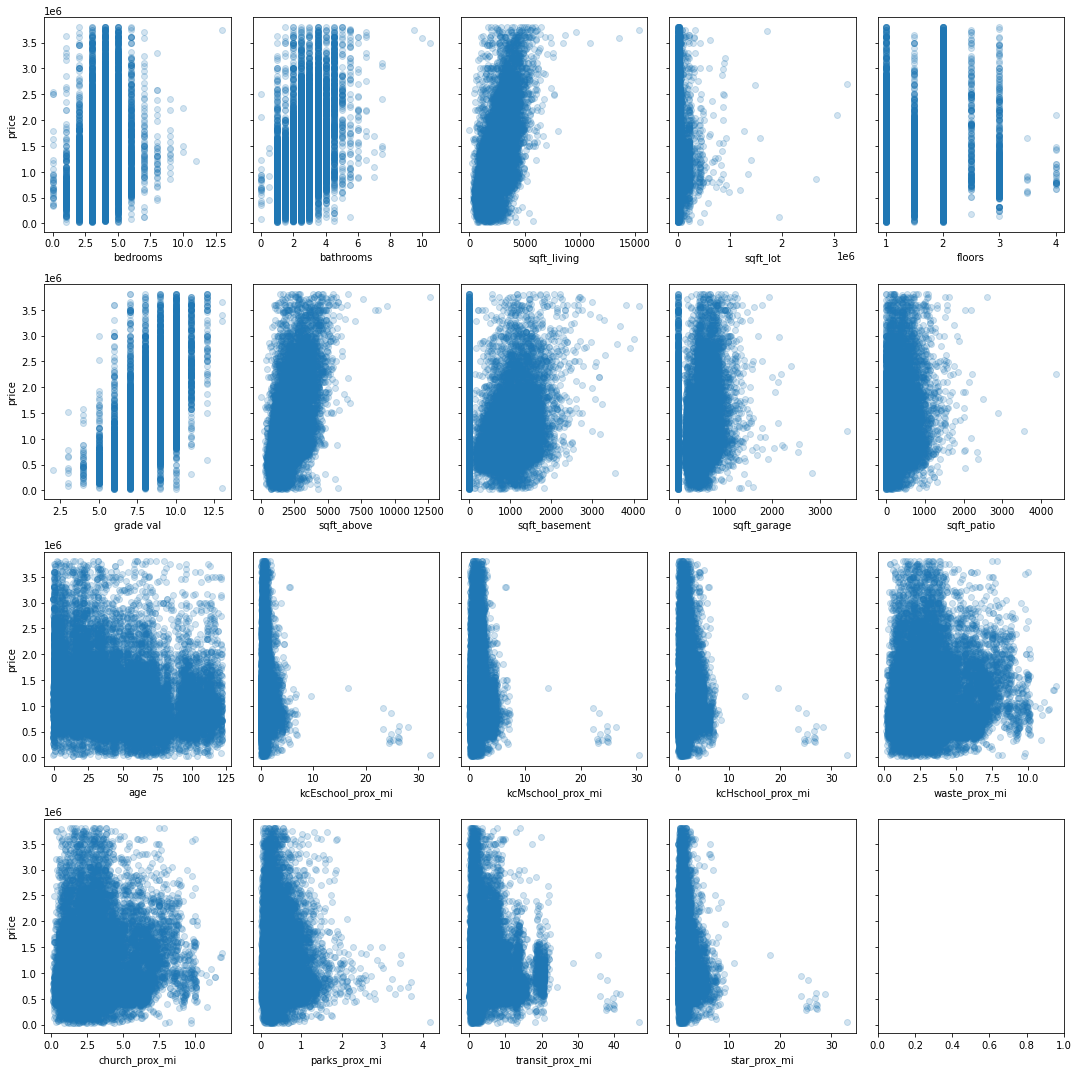

In [109]:
# Create scatter plots of each numeric feature compared to price.  Determine if any are suitable for log transformation
# to check for linearity.
y = kcdfmo_features["price"]
X = kcdfmo_features[kcdfmo_features.select_dtypes('number').drop(['price'],axis=1).columns]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,15), sharey=True)

for i, column in enumerate(X.columns):
    # Locate applicable axes
    row = i // 5
    col = i % 5
    ax = axes[row][col]
    
    # Plot feature vs. y and label axes
    ax.scatter(X[column], y, alpha=0.2)
    ax.set_xlabel(column)
    if col == 0:
        ax.set_ylabel("price")

fig.tight_layout()

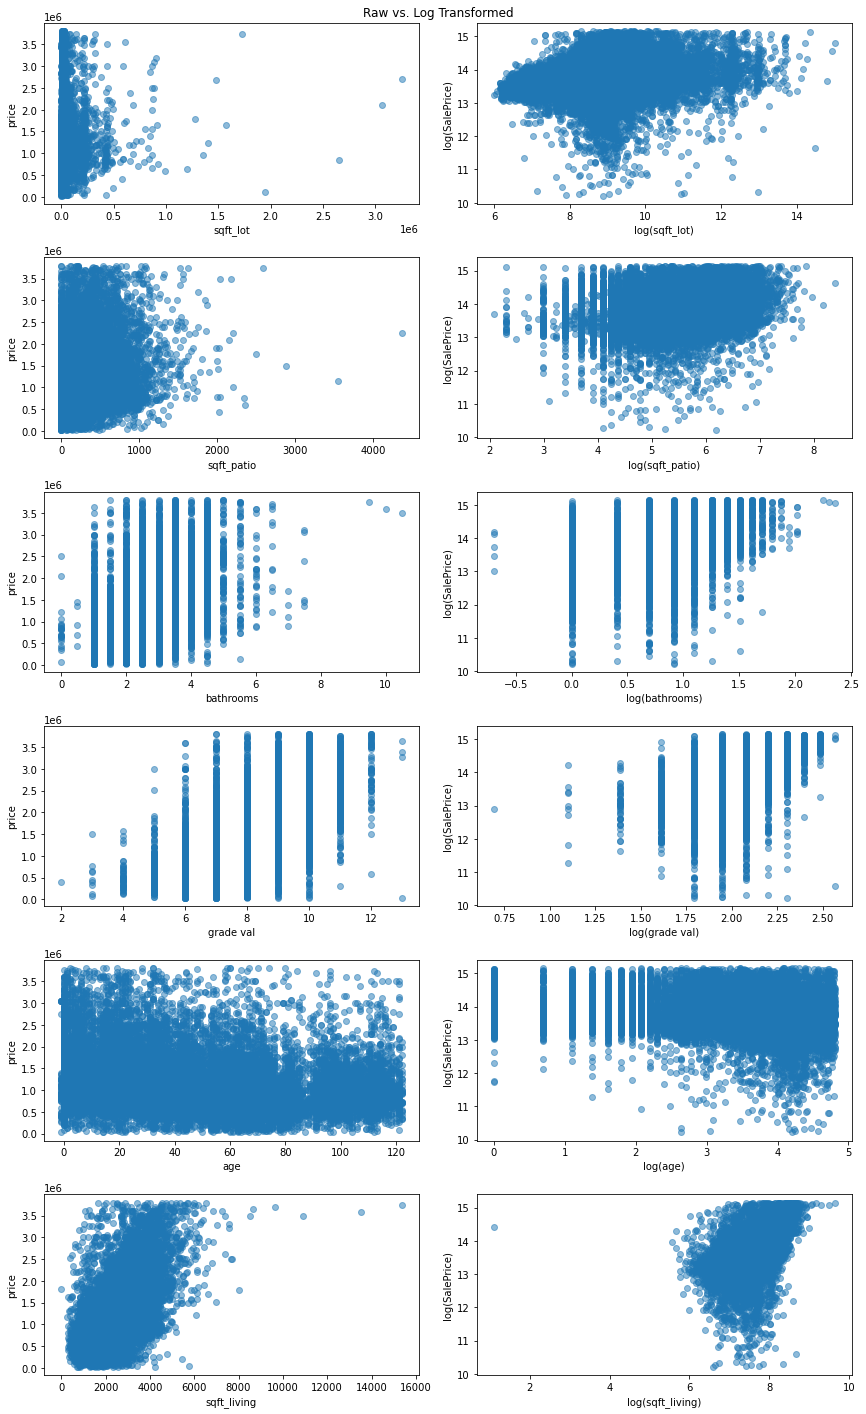

In [110]:
# Shapes of the "sqft_lot", "sqft_patio", "bathrooms",'grade val','age','sqft_living' graphs to be chceked for linearity
candidates = ["sqft_lot", "sqft_patio", "bathrooms",'grade val','age','sqft_living']

fig, axes = plt.subplots(ncols=2, nrows=len(candidates), figsize=(12,20))

for i, column in enumerate(candidates):
    # Plot raw version
    left_ax = axes[i][0]
    left_ax.scatter(kcdfmo_features[column], y, alpha=0.5)
    left_ax.set_xlabel(column)
    left_ax.set_ylabel("price")
    
    # Plot log transformed version
    right_ax = axes[i][1]
    right_ax.scatter(np.log(kcdfmo_features[column]), np.log(y), alpha=0.5)
    right_ax.set_xlabel(f"log({column})")
    right_ax.set_ylabel("log(SalePrice)")
    
fig.suptitle("Raw vs. Log Transformed")

fig.tight_layout()

#### log[price]

In [111]:
# price changed to log of price to use in the log plots to check for linearity
y_log = np.log(y)
y_log.name = "log_price"

#### log transformation [sqft living]

In [112]:
# Compare rsquared value for regular and transformed feature. If the rsquared value is greater for the log transformed
# feature, then the feature is not linear and removed from the final model.
Xliving = kcdfmo_features['sqft_living']

Xliving_log = kcdfmo_features['sqft_living'].copy()
Xliving_log = np.log(Xliving_log)
Xliving_log.name = "sqft_living"

modelliving = sm.OLS(endog=y, exog=sm.add_constant(Xliving))
resultsliving = modelliving.fit()

modelliving_log = sm.OLS(endog=y_log, exog=sm.add_constant(Xliving_log))
resultsliving_log = modelliving_log.fit()

print('Linear Rsqrd value is', resultsliving.rsquared_adj ,
      'and log transformed Rsqrd is', resultsliving_log.rsquared_adj)

Linear Rsqrd value is 0.40743212410009355 and log transformed Rsqrd is 0.32675159877684856


#### log transformation [bathrooms]

In [113]:
XBR = kcdfmo_features['bathrooms']

XBR_log = kcdfmo_features['bathrooms'].copy()
XBR_log = np.log(XBR+1)
XBR_log.name = "bathrooms"   

modelBR_log = sm.OLS(endog=y_log, exog=sm.add_constant(XBR_log))
resultsBR_log = modelBR_log.fit()

modelBR = sm.OLS(endog=y, exog=sm.add_constant(XBR))
resultsBR = modelBR.fit()

print('Linear Rsqrd value is', resultsBR.rsquared_adj ,
      'and log transformed Rsqrd is', resultsBR_log.rsquared_adj)

Linear Rsqrd value is 0.2498813546769596 and log transformed Rsqrd is 0.22271660374570723


#### log transformation [sqft lot]

In [114]:
Xlot = kcdfmo_features['sqft_lot']

Xlot_log = kcdfmo_features['sqft_lot'].copy()
Xlot_log = np.log(Xlot)
Xlot_log.name = "sqft_lot"

modellot = sm.OLS(endog=y, exog=sm.add_constant(Xlot))
resultslot = modellot.fit()

modellot_log = sm.OLS(endog=y_log, exog=sm.add_constant(Xlot_log))
resultslot_log = modellot_log.fit()

print('Linear Rsqrd value is', resultslot.rsquared_adj ,
      'and log transformed Rsqrd is', resultslot_log.rsquared_adj)

Linear Rsqrd value is 0.008795210587623115 and log transformed Rsqrd is 0.0198398489945798


#### log transformation [age]

In [115]:
Xage = kcdfmo_features['age']

Xage_log = kcdfmo_features['age'].copy()
Xage_log = np.log(Xage_log+1.1)
Xage_log.name = "age"
Xage_log   

modelage = sm.OLS(endog=y, exog=sm.add_constant(Xage))
resultsage = modelage.fit()

modelage_log = sm.OLS(endog=y_log, exog=sm.add_constant(Xage_log))
resultsage_log = modelage_log.fit()

print('Linear Rsqrd value is', resultsage.rsquared_adj ,
      'and log transformed Rsqrd is', resultsage_log.rsquared_adj)

Linear Rsqrd value is 0.021825472295047055 and log transformed Rsqrd is 0.021747497999161203


#### log transformation [sqft patio]

In [116]:
Xpatio = kcdfmo_features['sqft_patio']

Xpatio_log = kcdfmo_features['sqft_patio'].copy()
y_log = np.log(y)
Xpatio_log.name = "sqft_patio"
Xpatio_log   

modelpatio = sm.OLS(endog=y, exog=sm.add_constant(Xpatio))
resultspatio = modelpatio.fit()

modelpatio_log = sm.OLS(endog=y_log, exog=sm.add_constant(Xpatio_log))
resultspatio_log = modelpatio_log.fit()

print('Linear Rsqrd value is', resultspatio.rsquared_adj ,
      'and log transformed Rsqrd is', resultspatio_log.rsquared_adj)

Linear Rsqrd value is 0.08649474679350078 and log transformed Rsqrd is 0.075780138745012


#### log transformation [grade val]

In [117]:
Xgradv = kcdfmo_features['grade val']

Xgradv_log = kcdfmo_features['grade val'].copy()
y_log = np.log(y)
Xgradv_log.name = "grade val"
Xgradv_log   

modelgradv = sm.OLS(endog=y, exog=sm.add_constant(Xgradv))
resultsgradv = modelgradv.fit()

modelgradv_log = sm.OLS(endog=y_log, exog=sm.add_constant(Xgradv_log))
resultsgradv_log = modelgradv_log.fit()

print('Linear Rsqrd value is', resultsgradv.rsquared_adj ,
      'and log transformed Rsqrd is', resultsgradv_log.rsquared_adj)

Linear Rsqrd value is 0.38454274353656337 and log transformed Rsqrd is 0.34899023100492566


#### Conclusion
The only seleceted value that showed a slight improvement with the log transformation is sqft_lot. 

### Independance - Check for Colinearity

In [118]:
# Numeric features before one-hot encoding with location columns
numwd = kcdfmo_features.select_dtypes('number')
numwd

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade val,sqft_above,sqft_basement,sqft_garage,sqft_patio,age,kcEschool_prox_mi,kcMschool_prox_mi,kcHschool_prox_mi,waste_prox_mi,church_prox_mi,parks_prox_mi,transit_prox_mi,star_prox_mi
0,675000.0,4,1.0,1180,7140,1.0,7,1180,0,0,40,53,0.340336,0.476492,1.241054,1.600536,1.600536,0.584268,2.298407,1.148006
1,750000.0,3,2.0,1830,7969,1.0,7,930,930,240,90,14,0.587415,0.944820,1.042188,1.909783,1.909783,0.084149,1.260441,0.306163
2,728000.0,4,2.0,2170,7520,1.0,7,1240,1240,490,60,49,0.423767,0.593220,1.269118,1.461359,1.461359,0.545286,2.341829,1.115312
3,565000.0,4,2.0,1400,10364,1.5,6,1400,0,330,330,51,0.695935,0.912647,2.205839,2.714450,2.714450,0.705959,1.548849,0.704123
4,645000.0,3,2.0,1520,8250,1.0,8,1190,590,420,200,40,0.225745,0.511211,1.132772,1.645249,1.645249,0.517346,2.383377,1.261119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29137,395000.0,1,1.0,620,10400,1.5,6,620,0,0,100,41,26.201981,24.729601,26.615296,0.940667,0.940667,1.312926,39.781199,26.983483
29138,328000.0,2,1.5,980,5000,2.0,7,980,0,0,260,18,24.514366,23.151868,24.854750,0.957244,0.957244,0.618282,37.916433,25.292599
29139,600000.0,3,2.5,3150,989234,1.5,7,2150,1390,0,2360,39,27.940436,26.343423,28.442678,2.951827,2.951827,3.324140,41.768004,28.724867
29140,2451000.0,4,3.5,4050,204296,2.0,9,2280,1770,750,1250,37,2.033666,2.244347,4.415076,7.988979,7.988979,0.662403,9.530592,2.593044


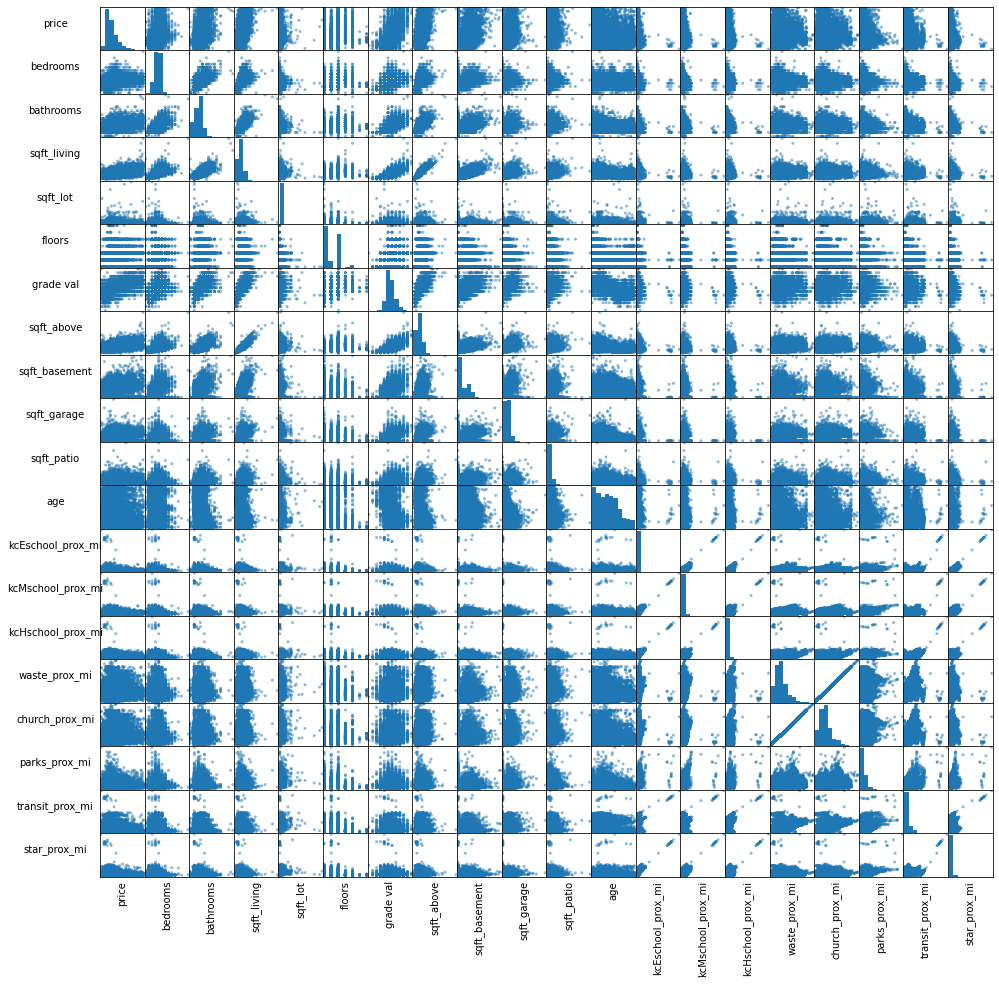

In [119]:
sm = pd.plotting.scatter_matrix(numwd, figsize=[16, 16]);

# Rotates the text
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

In [120]:
# creates a grid of scatter plots to see if there is any visual similarities showing collinearity
numwd.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade val,sqft_above,sqft_basement,sqft_garage,sqft_patio,age,kcEschool_prox_mi,kcMschool_prox_mi,kcHschool_prox_mi,waste_prox_mi,church_prox_mi,parks_prox_mi,transit_prox_mi,star_prox_mi
price,1.000000,0.338844,0.499907,0.638320,0.093967,0.242799,0.620132,0.561526,0.220932,0.278429,0.294154,-0.147850,0.002813,0.033477,0.069501,0.090734,0.090734,0.001045,-0.013417,-0.015442
bedrooms,0.338844,1.000000,0.586554,0.637716,0.000055,0.188930,0.372245,0.533788,0.223717,0.295640,0.174748,-0.185714,-0.018929,0.019280,0.019831,0.093262,0.093262,0.057124,0.045744,0.010374
bathrooms,0.499907,0.586554,1.000000,0.761008,0.037066,0.428891,0.625728,0.653069,0.231375,0.445255,0.305389,-0.487674,0.025380,0.068450,0.079194,0.148759,0.148759,0.093320,0.108096,0.030927
sqft_living,0.638320,0.637716,0.761008,1.000000,0.122382,0.359265,0.714901,0.871328,0.298444,0.490724,0.380260,-0.351148,0.066784,0.120564,0.141859,0.192150,0.192150,0.157874,0.159418,0.105861
sqft_lot,0.093967,0.000055,0.037066,0.122382,1.000000,-0.021562,0.058273,0.131000,0.000762,0.085516,0.160135,-0.013511,0.226781,0.208074,0.234680,0.125995,0.125995,0.270861,0.215240,0.286632
floors,0.242799,0.188930,0.428891,0.359265,-0.021562,1.000000,0.477052,0.514269,-0.259659,0.174709,0.117802,-0.533243,0.017875,0.035221,0.024720,0.087243,0.087243,0.016197,0.098335,-0.013434
grade val,0.620132,0.372245,0.625728,0.714901,0.058273,0.477052,1.000000,0.698390,0.100396,0.504171,0.323891,-0.493828,0.033916,0.077720,0.108841,0.179676,0.179676,0.099615,0.105340,0.039100
sqft_above,0.561526,0.533788,0.653069,0.871328,0.131000,0.514269,0.698390,1.000000,-0.130612,0.543259,0.293621,-0.442833,0.087140,0.150940,0.177237,0.250889,0.250889,0.219161,0.258434,0.143626
sqft_basement,0.220932,0.223717,0.231375,0.298444,0.000762,-0.259659,0.100396,-0.130612,1.000000,-0.011878,0.193133,0.225486,-0.046124,-0.062655,-0.072491,-0.112317,-0.112317,-0.126110,-0.204316,-0.078753
sqft_garage,0.278429,0.295640,0.445255,0.490724,0.085516,0.174709,0.504171,0.543259,-0.011878,1.000000,0.211407,-0.453354,0.069252,0.122184,0.153952,0.265262,0.265262,0.236210,0.241224,0.129268


In [121]:
# Identify any correlation values between features greater than .75 (1 being 100% correlated)
abs(numwd.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade val,sqft_above,sqft_basement,sqft_garage,sqft_patio,age,kcEschool_prox_mi,kcMschool_prox_mi,kcHschool_prox_mi,waste_prox_mi,church_prox_mi,parks_prox_mi,transit_prox_mi,star_prox_mi
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
grade val,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
sqft_garage,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [122]:
# Report any pair comboniation where the correlation value is greater than .75.
# A pair correlation greater than .75 indicates the two values are not independent from each other.
# Removing one from the pair will take away the collinearity of the pair.
df = numwd.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.871328
"(kcEschool_prox_mi, star_prox_mi)",0.779534
"(sqft_living, bathrooms)",0.761008


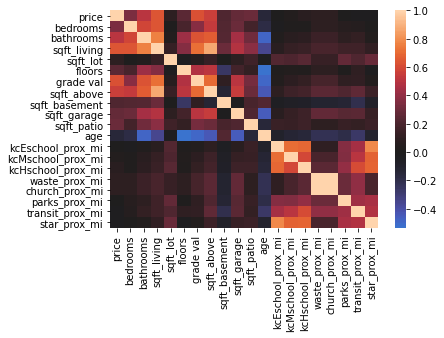

In [123]:
# Visual representation of the independance between each combination of features.
sns.heatmap(numwd.corr(), center=0);

#### Conclusion
There are three pair of features that appear to have enough correlation that they are not independant of each other.  Removing ['sqft_above'], ['star_prox_mi'], and ['bathrooms'] will remove the collinearity.

###  Normality - check for normal distribution

In [124]:
from statsmodels.stats.stattools import jarque_bera

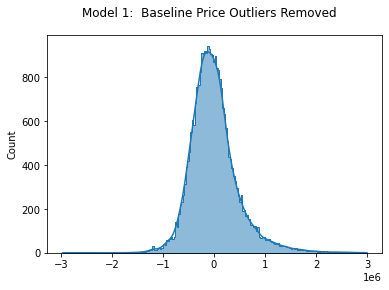

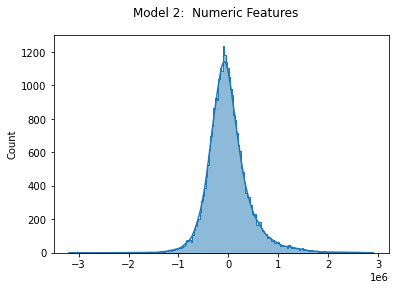

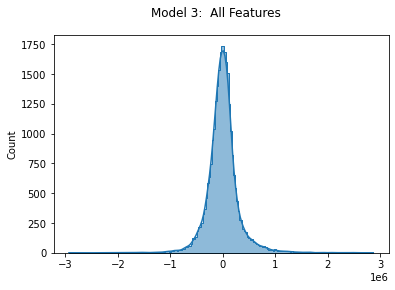

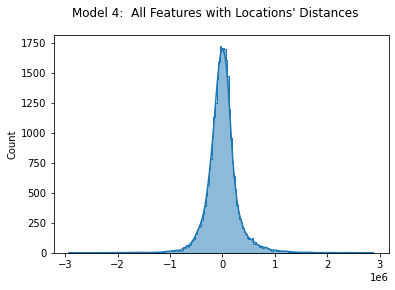

In [125]:
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,15), sharey=True)

fig, ax1 = plt.subplots()
sns.histplot(results1b.resid, bins=200, element="step", kde=True, ax=ax1)
ax.set_xlabel("Model Residuals")
fig.suptitle("Model 1:  Baseline Price Outliers Removed")

fig, ax2 = plt.subplots()
sns.histplot(results2.resid, bins=200, element="step", kde=True, ax=ax2)
ax.set_xlabel("Model Residuals")
fig.suptitle("Model 2:  Numeric Features")

fig, ax3 = plt.subplots()
sns.histplot(results3.resid, bins=200, element="step", kde=True, ax=ax3)
ax.set_xlabel("Model Residuals")
fig.suptitle("Model 3:  All Features")

fig, ax4 = plt.subplots()
sns.histplot(results4.resid, bins=200, element="step", kde=True, ax=ax4)
ax.set_xlabel("Model Residuals")
fig.suptitle("Model 4:  All Features with Locations' Distances");

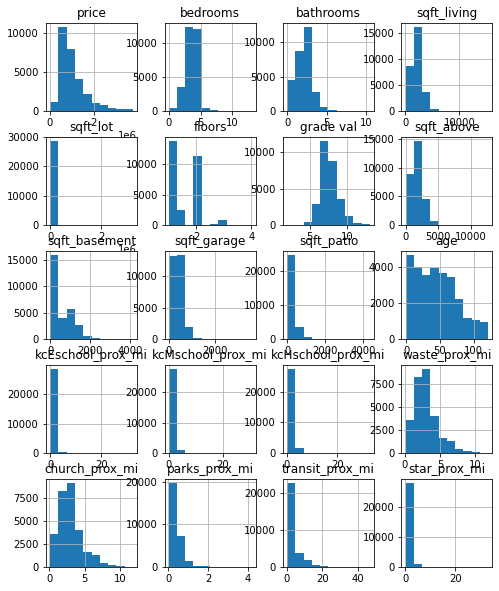

In [126]:
numcatwd[numwd.columns]\
    .hist(figsize=(8, 10));

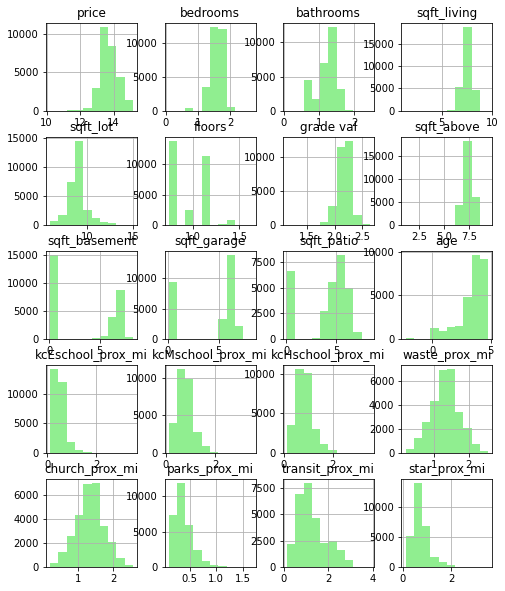

In [127]:
np.log(numcatwd[numwd.columns]+1.1)\
    .hist(figsize=(8, 10), color="lightgreen");

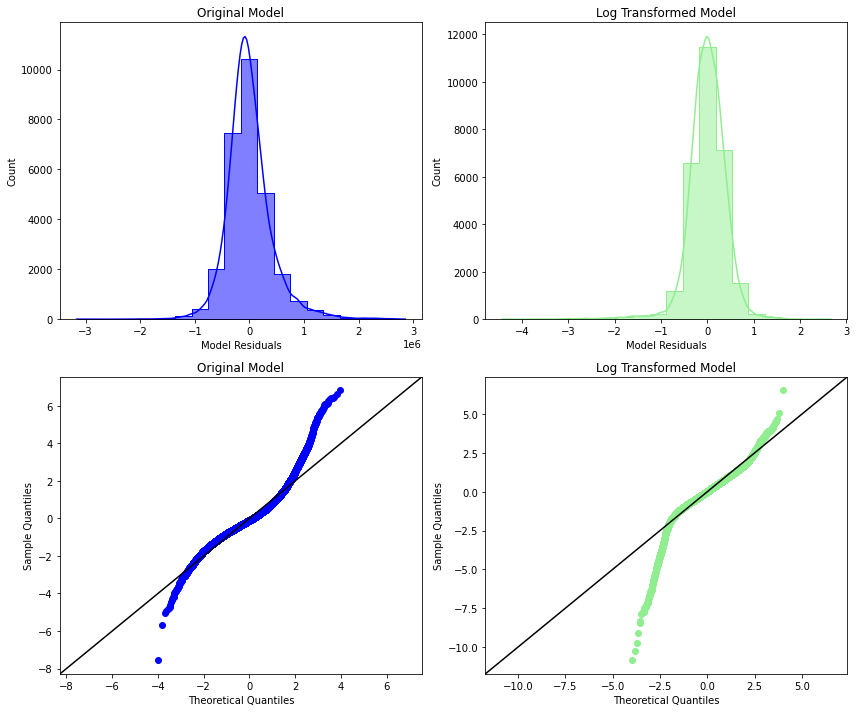

In [128]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

y = kcdfmo_features["price"]
X = kcdfmo_features[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'grade val',
       'sqft_above','floors',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'age',
       'kcEschool_prox_mi', 'kcMschool_prox_mi', 'kcHschool_prox_mi',
       'waste_prox_mi', 'church_prox_mi', 'parks_prox_mi', 'transit_prox_mi',
       'star_prox_mi']]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

# Build log transformed model
y_log = np.log(kcdfmo_features["price"])
X_log = pd.concat([np.log(kcdfmo_features[[ 'sqft_living', 'sqft_lot', 'grade val',
       'sqft_above','sqft_basement', 'sqft_patio',
       'kcEschool_prox_mi', 'kcMschool_prox_mi', 'kcHschool_prox_mi',
       'waste_prox_mi', 'church_prox_mi', 'parks_prox_mi', 'transit_prox_mi',
       'star_prox_mi']]+1.1), 
        kcdfmo_features[[ 'bedrooms','floors', 'age', 'bathrooms', 'sqft_garage']]], axis=1)
log_model = sm.OLS(y_log, sm.add_constant(X_log))
log_results = log_model.fit()

# Set up plot and properties of two models
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
resids = [results.resid, log_results.resid]
labels = ["Original Model", "Log Transformed Model"]
colors = ["blue", "lightgreen"]

# Plot histograms
for index, ax in enumerate(axes[0]):
    sns.histplot(resids[index], bins=20, element="step", kde=True, color=colors[index], ax=ax)
    ax.set_xlabel("Model Residuals")
    ax.set_title(labels[index])
    
# Plot Q-Q plots
for index, ax in enumerate(axes[1]):
    sm.graphics.qqplot(resids[index], dist=stats.norm, line='45', fit=True, ax=ax)
    scatter = ax.lines[0]
    line = ax.lines[1]
    scatter.set_markeredgecolor(colors[index])
    scatter.set_markerfacecolor(colors[index])
    line.set_color("black")
    ax.set_title(labels[index])
    
fig.tight_layout()

#### Conlusion
The normality has a normal but narrow ditribution.  This is seen both in the plots and the QQ plot with the S-like line. 

### Equal Variance

In [129]:
# Check the Baseline model for variance with the Goldfeld-Quandt test.
from statsmodels.stats.diagnostic import het_goldfeldquandt

In [130]:
# Using the X and y value from the baseline model with price outliers removed.
het_goldfeldquandt(y1b, X1b.values.reshape(-1,1), alternative='two-sided')

(0.8800666205888453, 1.9551515481137923e-14, 'two-sided')

#### Conclusion
The Goldfeld_Quandt test between price and sqft_living shows that it is heteroskedastic.

### Final Model
Price outliers removed; all numeric features, encoded categoric features, and distances to locations added; nonlinear and dependant features removed.

In [131]:
# Removed collinera features ('sqft_above','bathrooms','star_prox_mi') and a non-linear feature ('sqft_lot').
import pandas as pd
import numpy as np

final_features = numcatwd.drop(['price','sqft_lot','sqft_above','bathrooms','star_prox_mi'],axis=1).columns
#final_features
#numcatwd

In [132]:
# Features defined to determine final model
Xfinal = numcatwd[final_features]
yfinal = numcatwd["price"]

In [133]:
# Final model with LINE adjustments
modelfinal = sm.OLS(endog=yfinal, exog=sm.add_constant(Xfinal))
resultsfinal = modelfinal.fit()
resultsfinal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     710.4
Date:                Sun, 02 Oct 2022   Prob (F-statistic):               0.00
Time:                        06:29:34   Log-Likelihood:            -4.0363e+05
No. Observations:               28733   AIC:                         8.075e+05
Df Residuals:                   28614   BIC:                         8.085e+05
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            4.131e+05   1.65e+05      2.509      0.012    9.04e+04    7.36e+05
bedrooms                         2467.2544   2596.285      0.950      0.342   -2621.586    7556.095
sqft_living                       271.7567      4.193     64.818      0.000     263.539     279.974
floors                          -4.234e+04   5025.551     -8.425      0.000   -5.22e+04   -3.25e+04
grade val                       -4.477e+04   2.34e+04     -1.913      0.056   -9.06e+04    1098.719
sqft_basement                     -61.1925      4.379    -13.973      0.000     -69.777     -52.608
sqft_garage                        49.1307      9.101      5.398      0.000      31.292      66.969
sqft_patio                         37.2279      8.686      4.286      0.000      20.203      54.252
age                                 7.0298     94.910      0.074      0.941    -178.999     193.058
waterfront_YES                   2.271e+05   1.81e+04     12.564      0.000    1.92e+05    2.62e+05
greenbelt_YES                    3.157e+04   1.19e+04      2.661      0.008    8319.283    5.48e+04
nuisance_YES                    -4.772e+04   4995.187     -9.554      0.000   -5.75e+04   -3.79e+04
view_Excellent                    3.66e+05    1.8e+04     20.331      0.000    3.31e+05    4.01e+05
view_Fair                        5.802e+04    2.3e+04      2.527      0.012     1.3e+04    1.03e+05
view_Good                        9.097e+04    1.3e+04      7.003      0.000    6.55e+04    1.16e+05
view_None                       -9.603e+04   7825.650    -12.271      0.000   -1.11e+05   -8.07e+04
condition_Fair                  -5.522e+04    2.1e+04     -2.630      0.009   -9.64e+04   -1.41e+04
condition_Good                   4.801e+04   4634.060     10.361      0.000    3.89e+04    5.71e+04
condition_Poor                   -8.27e+04   4.13e+04     -2.002      0.045   -1.64e+05   -1730.275
condition_Very Good              1.086e+05   6445.193     16.855      0.000     9.6e+04    1.21e+05
grade desc_Better                3.399e+05   4.74e+04      7.178      0.000    2.47e+05    4.33e+05
grade desc_Excellent             8.326e+05   9.58e+04      8.690      0.000    6.45e+05    1.02e+06
grade desc_Fair                 -3.602e+04   4.93e+04     -0.730      0.465   -1.33e+05    6.07e+04
grade desc_Good                  1.075e+05   2.39e+04      4.497      0.000    6.07e+04    1.54e+05
grade desc_Low                  -3.118e+04    2.5e+04     -1.247      0.212   -8.02e+04    1.78e+04
grade desc_Luxury                9.366e+05   1.24e+05      7.547      0.000    6.93e+05    1.18e+06
grade desc_Mansion               2.019e+05   2.09e+05      0.968      0.333   -2.07e+05    6.11e+05
grade desc_Poor                 -8826.9306   1.39e+05     -0.064      0.949   -2.81

#### Model Final Conclusion
This final model has the price outliers removed with all of the nuemric, encoded categoric features and distances to select locations. Also, nonlinear and dependent featrues are removed.  The rsquared value explains $74\%$ of the price variance.  The coefficient represents a house with zero living area costs about $\$410,000$ and an increase of $\$270$ a square foot of living space,  $\$49$ a square foot of garage, and $\$37$ a sqare foot for patio space added to the house.  There are some features that add negative value.  The p value shows that most of the  features are statiscally relavent.

## Regression Results

In this analysis the best baseline model had an r-squared value that describes $41\%$ of housing price variance.  This was based on only one feature with a correlation of 63% to the prices.  After adding numeric features on the MLS sheet the r-squared value increased to explaining $51\%$ of housing price variance.  The highest r-squared value described the housing price variance at $75\%$ when the categoric features were introduced with one-hot encoding.  The linearity was checked with log transformation.  The features that were chosen all had a decrease in r-squared values except one that only increased by $1\%$.  The indepednece checked showed three pair of features that were collinear.  The normality of the model is normal but narrow.  The narrow distribution is verified with the QQ graph.  The variance of the data is not equally dispersed.  The final r-squared value describes the housing price variance at $74\%$ once the three collinear features and the one slightly non-linear feature were removed.

The approach to this analysis was to use everything in large chunks to see what made the most difference.  This analysis shows that MLS categoric features make the most improvement with and increase of $25\%$ to the model's predictability.  The MLS numeric feature had a $10\%$ increase above a base model. The distances to locations had a negligible effect on the model.  

Next steps are to look at each feature within the categoric and numeric features  to looking at p-values and find the minimum number of features with maximum predictability.  Knowing the features that have the most impact will help both pairs, seller and buyer and realestate agents and appraiser, to be insynch with the sell price of a home.
